# EDA and Data Cleaning 

## Import libraries and training and testing datasets

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
house = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

In [5]:
#look at datatypes
house.dtypes

Id                int64
PID               int64
MS SubClass       int64
MS Zoning        object
Lot Frontage    float64
                 ...   
Misc Val          int64
Mo Sold           int64
Yr Sold           int64
Sale Type        object
SalePrice         int64
Length: 81, dtype: object

In [6]:
test.dtypes

Id                int64
PID               int64
MS SubClass       int64
MS Zoning        object
Lot Frontage    float64
                 ...   
Misc Feature     object
Misc Val          int64
Mo Sold           int64
Yr Sold           int64
Sale Type        object
Length: 80, dtype: object

In [7]:
#look at what's in the dataframe
house.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [8]:
#rename the columns; make everything lowercase and replace spaces with underscores
house.columns = house.columns.map(lambda x: x.lower().replace(' ', '_'))

In [9]:
#do the same for the test dataset
test.columns = test.columns.map(lambda x: x.lower().replace(' ', '_'))

## Looking for and dealing with NaNs

In [10]:
#look at missing values
house.isnull().sum().sort_values(ascending=False).head(30)

pool_qc           2042
misc_feature      1986
alley             1911
fence             1651
fireplace_qu      1000
lot_frontage       330
garage_finish      114
garage_cond        114
garage_qual        114
garage_yr_blt      114
garage_type        113
bsmt_exposure       58
bsmtfin_type_2      56
bsmtfin_type_1      55
bsmt_cond           55
bsmt_qual           55
mas_vnr_type        22
mas_vnr_area        22
bsmt_half_bath       2
bsmt_full_bath       2
garage_cars          1
garage_area          1
bsmt_unf_sf          1
bsmtfin_sf_2         1
total_bsmt_sf        1
bsmtfin_sf_1         1
overall_cond         0
exterior_2nd         0
exterior_1st         0
roof_matl            0
dtype: int64

In [11]:
test.isnull().sum().sort_values(ascending=False).head(20)

pool_qc           874
misc_feature      837
alley             820
fence             706
fireplace_qu      422
lot_frontage      160
garage_cond        45
garage_qual        45
garage_yr_blt      45
garage_finish      45
garage_type        44
bsmt_exposure      25
bsmtfin_type_1     25
bsmt_qual          25
bsmtfin_type_2     25
bsmt_cond          25
mas_vnr_area        1
mas_vnr_type        1
electrical          1
overall_cond        0
dtype: int64

### Looks like there are 26 columns with missing values in the training, and 19 columns with missing values in the testing dataset.

According to the data dictionary/codebook online, an NA in these categories indicate that the feature does not exist:

    - alley
    - bsmt_exposure       
    - bsmtfin_type_2      
    - bsmtfin_type_1      
    - bsmt_cond           
    - bsmt_qual 
    - bsmt_half_bath   
    - bsmt_full_bath
    - bsmt_unf_sf 
    - bsmtfin_sf_2 
    - total_bsmt_sf
    - bsmtfin_sf_1 
    - fence          
    - fireplace_qu
    - garage_cond
    - garage_qual        
    - garage_yr_blt      
    - garage_finish      
    - garage_type   
    - garage_cars       
    - garage_area
    - pool_qc          
    - misc_feature 


Codebook says they use None to indicate there is no mas_vnr_area, so a NaN in mas_vnr_area should be changed to None

The two remaining categories unaccounted for are:

    - electrical (only in the testing data)
    - lot_frontage

## First, taking a look at the nulls in electrical and lot_frontage:

In [12]:
# what is the distribution of the electrical types in the dataset:

house['electrical'].value_counts()

SBrkr    1868
FuseA     140
FuseF      35
FuseP       7
Mix         1
Name: electrical, dtype: int64

In [13]:
test['electrical'].value_counts()

SBrkr    813
FuseA     48
FuseF     15
FuseP      1
Name: electrical, dtype: int64

## The electrical type is mostly circuit breaker, so since there is only one missing electrical value, I'm just going to make that one a circuit breaker

In [14]:
test['electrical'] = test['electrical'].fillna('SBrkr')

In [15]:
test['electrical'].isnull().sum()

0

## Now, looking at lot_frontage.
The codebook says that lot frontage means "Linear feet of street connected to property". It doesn't specify that there should be a null value.

In [16]:
house['lot_frontage'].describe()

count    1721.000000
mean       69.055200
std        23.260653
min        21.000000
25%        58.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: lot_frontage, dtype: float64

And when I looked at the minimum value (above), it wasn't zero. 
Also, I looked at a map of Ames and it doesn't seem like a house in that area would not have a street connected to it.
Therefore, I want to replace it with either the median of all the other properties. 

In [17]:
#replace nans with median lot frontage
house['lot_frontage'] = house['lot_frontage'].fillna(house['lot_frontage'].median())

In [18]:
# these values are missing from the test one too so I'll fix that here
test['lot_frontage'] = test['lot_frontage'].fillna(test['lot_frontage'].median())

## Dealing with the NaNs in the list of columns I made earlier
I'm going through them one by one.

### Alley

In [19]:
#looking at the alley column:

house['alley'].value_counts()

Grvl    85
Pave    55
Name: alley, dtype: int64

In [20]:
house['alley'].isnull().sum()

1911

In [21]:
house['alley'].shape

(2051,)

In [22]:
# most of the houses don't have alleys, but it might make a difference.
# I'm replacing the NaNs with no_alley in both the training and the testing sets
# so that I can have dummy columns later

house['alley'] = house['alley'].fillna('no_alley')
test['alley'] = test['alley'].fillna('no_alley')

## Basement features
some of these features are quantitative, and the others are qualititative:

qualitative features:
- bsmt_exposure       
- bsmtfin_type_2      
- bsmtfin_type_1      
- bsmt_cond           
- bsmt_qual 

quantitative features:
- bsmt_half_bath   
- bsmt_full_bath
- bsmt_unf_sf 
- bsmtfin_sf_2 
- total_bsmt_sf
- bsmtfin_sf_1 

so for the qualitative ones, I will replace nans with 'no_basement' and the quantitative ones, I will replace nans with 0

In [23]:
basement1 = ['bsmt_exposure', 'bsmtfin_type_2', 'bsmtfin_type_1', 'bsmt_cond', 'bsmt_qual']
basement2 = ['bsmt_half_bath', 'bsmt_full_bath', 'bsmt_unf_sf', 'bsmtfin_sf_2', 'total_bsmt_sf', 'bsmtfin_sf_1']

#replace nans in training
house[basement1] = house[basement1].fillna('no_basement')
house[basement2] = house[basement2].fillna(0)

#replace nans in testing
test[basement1] = test[basement1].fillna('no_basement')
test[basement2] = test[basement2].fillna(0)

## Fence
Replace NaNs in training and testing with 'no_fence'

In [24]:
house['fence'] = house['fence'].fillna('no_fence')
test['fence'] = test['fence'].fillna('no_fence')

## Fireplace

Replace NaNs in training and testing with 'no_fire'

In [25]:
house['fireplace_qu'] = house['fireplace_qu'].fillna('no_fire')
test['fireplace_qu'] = test['fireplace_qu'].fillna('no_fire')

## Garage

Replace NaNs in training and testing with 'no_garage' or 0s, depending on if they're qualitative or quantitative.

In [26]:
garage1 = ['garage_cond', 'garage_qual', 'garage_yr_blt', 'garage_finish', 'garage_type']  
garage2 = ['garage_cars','garage_area']

#replace nans in training
house[garage1] = house[garage1].fillna('no_garage')
house[garage2] = house[garage2].fillna(0)

#replace nans in testing
test[garage1] = test[garage1].fillna('no_garage')
test[garage2] = test[garage2].fillna(0)

## Pool QC

Replace NaNs in training and testing with 'no_pool'

In [27]:
house['pool_qc'] = house['pool_qc'].fillna('no_pool')
test['pool_qc'] = test['pool_qc'].fillna('no_pool')

## Masonry Veneer Type and Area

Replace NaNs in type column of training and testing with 'no_veneer'
Replace NaNs in area column of training and testing with 0

In [28]:
house['mas_vnr_type'] = house['mas_vnr_type'].fillna('no_veneer')
test['mas_vnr_type'] = test['mas_vnr_type'].fillna('no_veneer')

house['mas_vnr_area'] = house['mas_vnr_area'].fillna(0)
test['mas_vnr_area'] = test['mas_vnr_area'].fillna(0)

## Misc Features

Replace NaNs in training and testing with 'no_extras'

In [29]:
house['misc_feature'] = house['misc_feature'].fillna('no_extras')
test['misc_feature'] = test['misc_feature'].fillna('no_extras')

## Double check everything got filled

In [30]:
house.isnull().sum().sort_values(ascending=False)

saleprice         0
total_bsmt_sf     0
year_remod/add    0
roof_style        0
roof_matl         0
                 ..
kitchen_qual      0
totrms_abvgrd     0
functional        0
fireplaces        0
id                0
Length: 81, dtype: int64

In [31]:
test.isnull().sum().sort_values(ascending=False)

sale_type         0
yr_sold           0
year_remod/add    0
roof_style        0
roof_matl         0
                 ..
kitchen_qual      0
totrms_abvgrd     0
functional        0
fireplaces        0
id                0
Length: 80, dtype: int64

## Not all numbers should be treated as numerical
Change some number columns into strings because the numbers represent a category that needs to be dummified

In [32]:
num_to_string = ['ms_subclass', 'mo_sold', 'yr_sold']

house[num_to_string] = house[num_to_string].astype(object)
test[num_to_string] = test[num_to_string].astype(object)

### Look at the y variable:
Here I take a look at the y variable (sale price) and see that it has a bit of a skew. 
I want to normalize it, so I take the log of it.

(array([ 42., 525., 818., 350., 168.,  79.,  40.,  16.,   6.,   7.]),
 array([ 12789. ,  72675.8, 132562.6, 192449.4, 252336.2, 312223. ,
        372109.8, 431996.6, 491883.4, 551770.2, 611657. ]),
 <BarContainer object of 10 artists>)

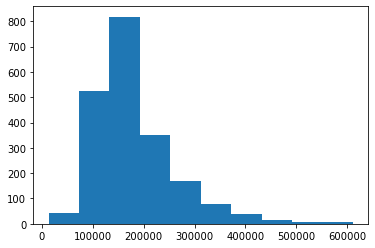

In [33]:
y = house['saleprice']
plt.hist(y)

In [34]:
house['logsaleprice'] = np.log(house['saleprice'])

(array([  2.,   0.,   6.,  13.,  81., 440., 835., 462., 177.,  35.]),
 array([ 9.45634071,  9.84309933, 10.22985795, 10.61661658, 11.0033752 ,
        11.39013383, 11.77689245, 12.16365107, 12.5504097 , 12.93716832,
        13.32392695]),
 <BarContainer object of 10 artists>)

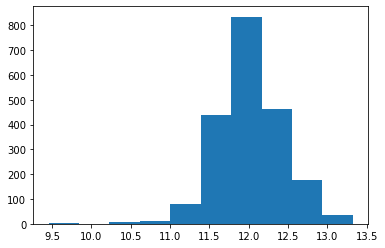

In [35]:
y = house['logsaleprice']
plt.hist(y)

### Dummifying everything that isn't numerical, and then dropping the columns that were dummified:

In [36]:
dummies = house.select_dtypes('object')

In [37]:
dummified = pd.get_dummies(dummies)

In [38]:
house = pd.concat([house, dummified], axis=1)

In [39]:
house = house.drop(dummies, axis=1)

### Do the same thing for the test data

In [40]:
test_dummies = test.select_dtypes('object')

In [41]:
test_dummified = pd.get_dummies(test_dummies)

In [42]:
test = pd.concat([test, test_dummified], axis=1)

In [43]:
test = test.drop(test_dummies, axis=1)

In [44]:
test.shape

(878, 409)

In [45]:
house.shape

(2051, 438)

### There are more columns in the training set than in the testing set
Which columns are different?
I'll see if it matters later.

Ok it does matter, standard scaler won't work if the two don't have the same number of columns

In [46]:
test_name = test.columns

In [47]:
house_name = house.columns

In [48]:
house_name.symmetric_difference(test_name)

Index(['bsmt_cond_Ex', 'bsmt_cond_Po', 'condition_2_Artery',
       'condition_2_PosN', 'condition_2_RRAe', 'condition_2_RRAn',
       'condition_2_RRNn', 'electrical_Mix', 'exterior_1st_CBlock',
       'exterior_1st_ImStucc', 'exterior_1st_PreCast', 'exterior_1st_Stone',
       'exterior_2nd_Other', 'exterior_2nd_PreCast', 'exterior_2nd_Stone',
       'functional_Sal', 'functional_Sev', 'garage_qual_Ex',
       'garage_yr_blt_1895.0', 'garage_yr_blt_1896.0', 'garage_yr_blt_1906.0',
       'garage_yr_blt_1908.0', 'garage_yr_blt_1914.0', 'garage_yr_blt_1919.0',
       'garage_yr_blt_1929.0', 'garage_yr_blt_1933.0', 'garage_yr_blt_1936.0',
       'garage_yr_blt_1942.0', 'garage_yr_blt_1943.0', 'garage_yr_blt_1945.0',
       'garage_yr_blt_2207.0', 'heating_Floor', 'heating_OthW', 'heating_Wall',
       'heating_qc_Po', 'kitchen_qual_Po', 'logsaleprice',
       'mas_vnr_type_CBlock', 'misc_feature_Elev', 'misc_feature_TenC',
       'ms_subclass_150', 'ms_zoning_A (agr)', 'neighborhood_Grn

In [49]:
test = test.drop(['exterior_1st_PreCast', 'exterior_2nd_Other' ,'exterior_2nd_PreCast', 'garage_yr_blt_1906.0','garage_yr_blt_1908.0', 'garage_yr_blt_1943.0','heating_Floor' ,'kitchen_qual_Po' ,'mas_vnr_type_CBlock' ,'roof_matl_Metal', 'roof_matl_Roll' ,'sale_type_VWD'], axis=1)

In [50]:
test_name = test.columns

In [51]:
house_name.symmetric_difference(test_name)

Index(['bsmt_cond_Ex', 'bsmt_cond_Po', 'condition_2_Artery',
       'condition_2_PosN', 'condition_2_RRAe', 'condition_2_RRAn',
       'condition_2_RRNn', 'electrical_Mix', 'exterior_1st_CBlock',
       'exterior_1st_ImStucc', 'exterior_1st_Stone', 'exterior_2nd_Stone',
       'functional_Sal', 'functional_Sev', 'garage_qual_Ex',
       'garage_yr_blt_1895.0', 'garage_yr_blt_1896.0', 'garage_yr_blt_1914.0',
       'garage_yr_blt_1919.0', 'garage_yr_blt_1929.0', 'garage_yr_blt_1933.0',
       'garage_yr_blt_1936.0', 'garage_yr_blt_1942.0', 'garage_yr_blt_1945.0',
       'garage_yr_blt_2207.0', 'heating_OthW', 'heating_Wall', 'heating_qc_Po',
       'logsaleprice', 'misc_feature_Elev', 'misc_feature_TenC',
       'ms_subclass_150', 'ms_zoning_A (agr)', 'neighborhood_GrnHill',
       'neighborhood_Landmrk', 'pool_qc_Fa', 'pool_qc_Gd', 'roof_matl_ClyTile',
       'roof_matl_Membran', 'saleprice', 'utilities_NoSeWa'],
      dtype='object')

In [52]:
house = house.drop(['bsmt_cond_Ex', 'bsmt_cond_Po', 'condition_2_Artery',
       'condition_2_PosN', 'condition_2_RRAe', 'condition_2_RRAn',
       'condition_2_RRNn', 'electrical_Mix', 'exterior_1st_CBlock',
       'exterior_1st_ImStucc', 'exterior_1st_Stone', 'exterior_2nd_Stone',
       'functional_Sal', 'functional_Sev', 'garage_qual_Ex',
       'garage_yr_blt_1895.0', 'garage_yr_blt_1896.0', 'garage_yr_blt_1914.0',
       'garage_yr_blt_1919.0', 'garage_yr_blt_1929.0', 'garage_yr_blt_1933.0',
       'garage_yr_blt_1936.0', 'garage_yr_blt_1942.0', 'garage_yr_blt_1945.0',
       'garage_yr_blt_2207.0', 'heating_OthW', 'heating_Wall', 'heating_qc_Po',
        'misc_feature_Elev', 'misc_feature_TenC',
       'ms_subclass_150', 'ms_zoning_A (agr)', 'neighborhood_GrnHill',
       'neighborhood_Landmrk', 'pool_qc_Fa', 'pool_qc_Gd', 'roof_matl_ClyTile',
       'roof_matl_Membran', 'utilities_NoSeWa'], axis=1)

In [53]:
house.shape

(2051, 399)

In [54]:
test.shape

(878, 397)

## Looking at correlations

In [55]:
corr = house.corr()

In [56]:
corr.saleprice.sort_values(ascending=False).head(20)

saleprice             1.000000
logsaleprice          0.946134
overall_qual          0.800207
gr_liv_area           0.697038
garage_area           0.649897
garage_cars           0.647781
total_bsmt_sf         0.629303
1st_flr_sf            0.618486
bsmt_qual_Ex          0.586497
year_built            0.571849
kitchen_qual_Ex       0.551284
year_remod/add        0.550370
full_bath             0.537969
foundation_PConc      0.529047
totrms_abvgrd         0.504014
mas_vnr_area          0.503579
exter_qual_Ex         0.493861
fireplaces            0.471093
bsmtfin_type_1_GLQ    0.463549
heating_qc_Ex         0.453255
Name: saleprice, dtype: float64

#### Let's just keep the features that are either highly positively or negatively correlated
ie: get rid of the features that are not correlated with price

In [55]:
corr_df = pd.DataFrame(corr.saleprice)

In [56]:
corr_df[corr_df['saleprice'] > .2].index

Index(['lot_frontage', 'lot_area', 'overall_qual', 'year_built',
       'year_remod/add', 'mas_vnr_area', 'bsmtfin_sf_1', 'total_bsmt_sf',
       '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area', 'bsmt_full_bath',
       'full_bath', 'half_bath', 'totrms_abvgrd', 'fireplaces', 'garage_cars',
       'garage_area', 'wood_deck_sf', 'open_porch_sf', 'saleprice',
       'logsaleprice', 'ms_subclass_60', 'ms_zoning_RL', 'lot_shape_IR1',
       'land_contour_HLS', 'neighborhood_NoRidge', 'neighborhood_NridgHt',
       'neighborhood_StoneBr', 'house_style_2Story', 'roof_style_Hip',
       'exterior_1st_VinylSd', 'exterior_2nd_VinylSd', 'mas_vnr_type_BrkFace',
       'mas_vnr_type_Stone', 'exter_qual_Ex', 'exter_qual_Gd',
       'foundation_PConc', 'bsmt_qual_Ex', 'bsmt_qual_Gd', 'bsmt_exposure_Gd',
       'bsmtfin_type_1_GLQ', 'heating_qc_Ex', 'central_air_Y',
       'electrical_SBrkr', 'kitchen_qual_Ex', 'kitchen_qual_Gd',
       'fireplace_qu_Ex', 'fireplace_qu_Gd', 'garage_type_Attchd',
       'ga

In [57]:
corr_df[corr_df['saleprice'] < -.2].index

Index(['pid', 'ms_subclass_30', 'ms_zoning_RM', 'lot_shape_Reg',
       'neighborhood_OldTown', 'roof_style_Gable', 'mas_vnr_type_None',
       'exter_qual_TA', 'foundation_BrkTil', 'foundation_CBlock',
       'bsmt_qual_TA', 'bsmt_exposure_No', 'heating_qc_TA', 'central_air_N',
       'electrical_FuseA', 'kitchen_qual_TA', 'fireplace_qu_no_fire',
       'garage_type_Detchd', 'garage_type_no_garage',
       'garage_yr_blt_no_garage', 'garage_finish_Unf',
       'garage_finish_no_garage', 'garage_qual_no_garage',
       'garage_cond_no_garage', 'paved_drive_N', 'sale_type_WD '],
      dtype='object')

In [58]:
corr_features = ['id', 'pid', 'ms_subclass_30', 'ms_zoning_RM', 'lot_shape_Reg',
       'neighborhood_OldTown', 'roof_style_Gable', 'mas_vnr_type_None',
       'exter_qual_TA', 'foundation_BrkTil', 'foundation_CBlock',
       'bsmt_qual_TA', 'bsmt_exposure_No', 'heating_qc_TA', 'central_air_N',
       'electrical_FuseA', 'kitchen_qual_TA', 'fireplace_qu_no_fire',
       'garage_type_Detchd', 'garage_type_no_garage',
       'garage_yr_blt_no_garage', 'garage_finish_Unf',
       'garage_finish_no_garage', 'garage_qual_no_garage',
       'garage_cond_no_garage', 'paved_drive_N', 'sale_type_WD ', 'lot_frontage', 'lot_area', 'overall_qual', 'year_built',
       'year_remod/add', 'mas_vnr_area', 'bsmtfin_sf_1', 'total_bsmt_sf',
       '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area', 'bsmt_full_bath',
       'full_bath', 'half_bath', 'totrms_abvgrd', 'fireplaces', 'garage_cars',
       'garage_area', 'wood_deck_sf', 'open_porch_sf', 'saleprice',
       'logsaleprice', 'ms_subclass_60', 'ms_zoning_RL', 'lot_shape_IR1',
       'land_contour_HLS', 'neighborhood_NoRidge', 'neighborhood_NridgHt',
       'neighborhood_StoneBr', 'house_style_2Story', 'roof_style_Hip',
       'exterior_1st_VinylSd', 'exterior_2nd_VinylSd', 'mas_vnr_type_BrkFace',
       'mas_vnr_type_Stone', 'exter_qual_Ex', 'exter_qual_Gd',
       'foundation_PConc', 'bsmt_qual_Ex', 'bsmt_qual_Gd', 'bsmt_exposure_Gd',
       'bsmtfin_type_1_GLQ', 'heating_qc_Ex', 'central_air_Y',
       'electrical_SBrkr', 'kitchen_qual_Ex', 'kitchen_qual_Gd',
       'fireplace_qu_Ex', 'fireplace_qu_Gd', 'garage_type_Attchd',
       'garage_type_BuiltIn', 'garage_yr_blt_2006.0', 'garage_yr_blt_2008.0',
       'garage_finish_Fin', 'garage_qual_TA', 'garage_cond_TA',
       'paved_drive_Y', 'sale_type_New']
test_features = ['id', 'pid', 'ms_subclass_30', 'ms_zoning_RM', 'lot_shape_Reg',
       'neighborhood_OldTown', 'roof_style_Gable', 'mas_vnr_type_None',
       'exter_qual_TA', 'foundation_BrkTil', 'foundation_CBlock',
       'bsmt_qual_TA', 'bsmt_exposure_No', 'heating_qc_TA', 'central_air_N',
       'electrical_FuseA', 'kitchen_qual_TA', 'fireplace_qu_no_fire',
       'garage_type_Detchd', 'garage_type_no_garage',
       'garage_yr_blt_no_garage', 'garage_finish_Unf',
       'garage_finish_no_garage', 'garage_qual_no_garage',
       'garage_cond_no_garage', 'paved_drive_N', 'sale_type_WD ', 'lot_frontage', 'lot_area', 'overall_qual', 'year_built',
       'year_remod/add', 'mas_vnr_area', 'bsmtfin_sf_1', 'total_bsmt_sf',
       '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area', 'bsmt_full_bath',
       'full_bath', 'half_bath', 'totrms_abvgrd', 'fireplaces', 'garage_cars',
       'garage_area', 'wood_deck_sf', 'open_porch_sf', 'ms_subclass_60', 'ms_zoning_RL', 'lot_shape_IR1',
       'land_contour_HLS', 'neighborhood_NoRidge', 'neighborhood_NridgHt',
       'neighborhood_StoneBr', 'house_style_2Story', 'roof_style_Hip',
       'exterior_1st_VinylSd', 'exterior_2nd_VinylSd', 'mas_vnr_type_BrkFace',
       'mas_vnr_type_Stone', 'exter_qual_Ex', 'exter_qual_Gd',
       'foundation_PConc', 'bsmt_qual_Ex', 'bsmt_qual_Gd', 'bsmt_exposure_Gd',
       'bsmtfin_type_1_GLQ', 'heating_qc_Ex', 'central_air_Y',
       'electrical_SBrkr', 'kitchen_qual_Ex', 'kitchen_qual_Gd',
       'fireplace_qu_Ex', 'fireplace_qu_Gd', 'garage_type_Attchd',
       'garage_type_BuiltIn', 'garage_yr_blt_2006.0', 'garage_yr_blt_2008.0',
       'garage_finish_Fin', 'garage_qual_TA', 'garage_cond_TA']

house_corr = house[corr_features]
test_corr = test[test_features]

In [59]:
house_corr.shape

(2051, 85)

In [60]:
test_corr.shape

(878, 81)

In [61]:
house_corr_name = house_corr.columns
test_corr_name = test_corr.columns

In [62]:
house_corr_name.symmetric_difference(test_corr_name)

Index(['logsaleprice', 'paved_drive_Y', 'sale_type_New', 'saleprice'], dtype='object')

In [63]:
house_corr = house_corr.drop(['paved_drive_Y', 'sale_type_New'], axis=1)

### Saving the cleaned datasets

In [64]:
house.to_csv('./datasets/house_clean.csv')
test.to_csv('./datasets/test_clean.csv')

In [65]:
house_corr.to_csv('./datasets/house_corr_features.csv')
test_corr.to_csv('./datasets/test_corr_features.csv')